In [1]:
!pip install transformers datasets
!pip install transformers datasets -q
!pip install datasets
!pip install imblearn
!pip install datasets transformers scikit-learn --quiet
!pip install -q transformers datasets evaluate accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system =

In [2]:
import pandas as pd

lfc_lda_url = 'https://raw.githubusercontent.com/WinNatch/UoB_SM-WA/main/LFC_LDA.csv'

lfc_df = pd.read_csv(lfc_lda_url)

print(lfc_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7547 entries, 0 to 7546
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        7547 non-null   object
 1   time        1970 non-null   object
 2   headline    7547 non-null   object
 3   news_text   7547 non-null   object
 4   reporter    7547 non-null   object
 5   news        7547 non-null   object
 6   clean_news  7547 non-null   object
 7   lda_no      7547 non-null   int64 
 8   lda_topic   5624 non-null   object
dtypes: int64(1), object(8)
memory usage: 530.8+ KB
None


In [3]:
lfc_df["lda_topic"] = lfc_df["lda_topic"].replace({
    "24-25 Summer Market": "Summer Market",
    "LFC Derby Drama": "Performance Analysis",
    "Salah Contract Renew": "Mohamed Salah",
    "LFC-Alonso": "Klopp Replacement",
    "VanDijk Contract Renew": "Van Dijk"
})

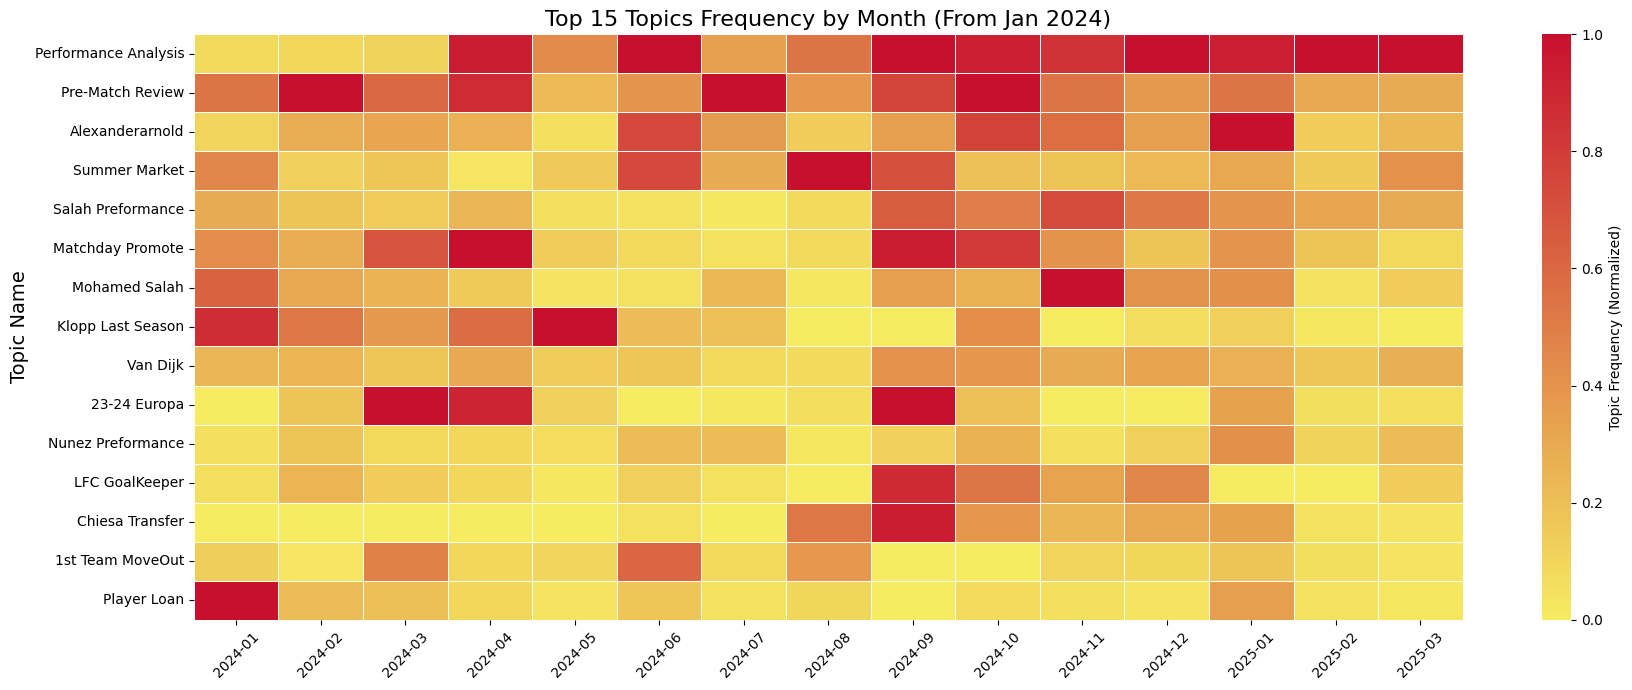

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import MinMaxScaler

lfc_df["date"] = pd.to_datetime(lfc_df["date"], errors="coerce")
lfc_df = lfc_df.dropna(subset=["date"])
lfc_df = lfc_df[lfc_df["date"] >= "2024-01-01"]

lfc_df["month"] = lfc_df["date"].dt.to_period("M").astype(str)

top_topics = lfc_df["lda_topic"].value_counts().nlargest(20).index.tolist()
filtered_df = lfc_df[lfc_df["lda_topic"].isin(top_topics)]

count_df = filtered_df.groupby(["month", "lda_topic"]).size().reset_index(name="count")

pivot_count = count_df.pivot(index="lda_topic", columns="month", values="count").fillna(0)

topic_order = pivot_count.sum(axis=1).sort_values(ascending=False).index.tolist()
pivot_count = pivot_count.loc[topic_order]
pivot_count = pivot_count.iloc[:15]

pivot_count = pivot_count.reindex(sorted(pivot_count.columns), axis=1)

scaler = MinMaxScaler()
topic_month_counts_normalized = pd.DataFrame(scaler.fit_transform(pivot_count), columns=pivot_count.columns, index=pivot_count.index)

colors = ["#F6EB61", "#c8102E"]
custom_cmap = LinearSegmentedColormap.from_list("custom_red_yellow", colors, N=256)

plt.figure(figsize=(18, 7))
sns.heatmap(
    topic_month_counts_normalized,
    cmap=custom_cmap,
    linewidths=0.5,
    annot=False,
    cbar_kws={"label": "Topic Frequency (Normalized)"}
)

plt.xlabel("", fontsize=12)
plt.ylabel("Topic Name", fontsize=14)
plt.title("Top 15 Topics Frequency by Month (From Jan 2024)", fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

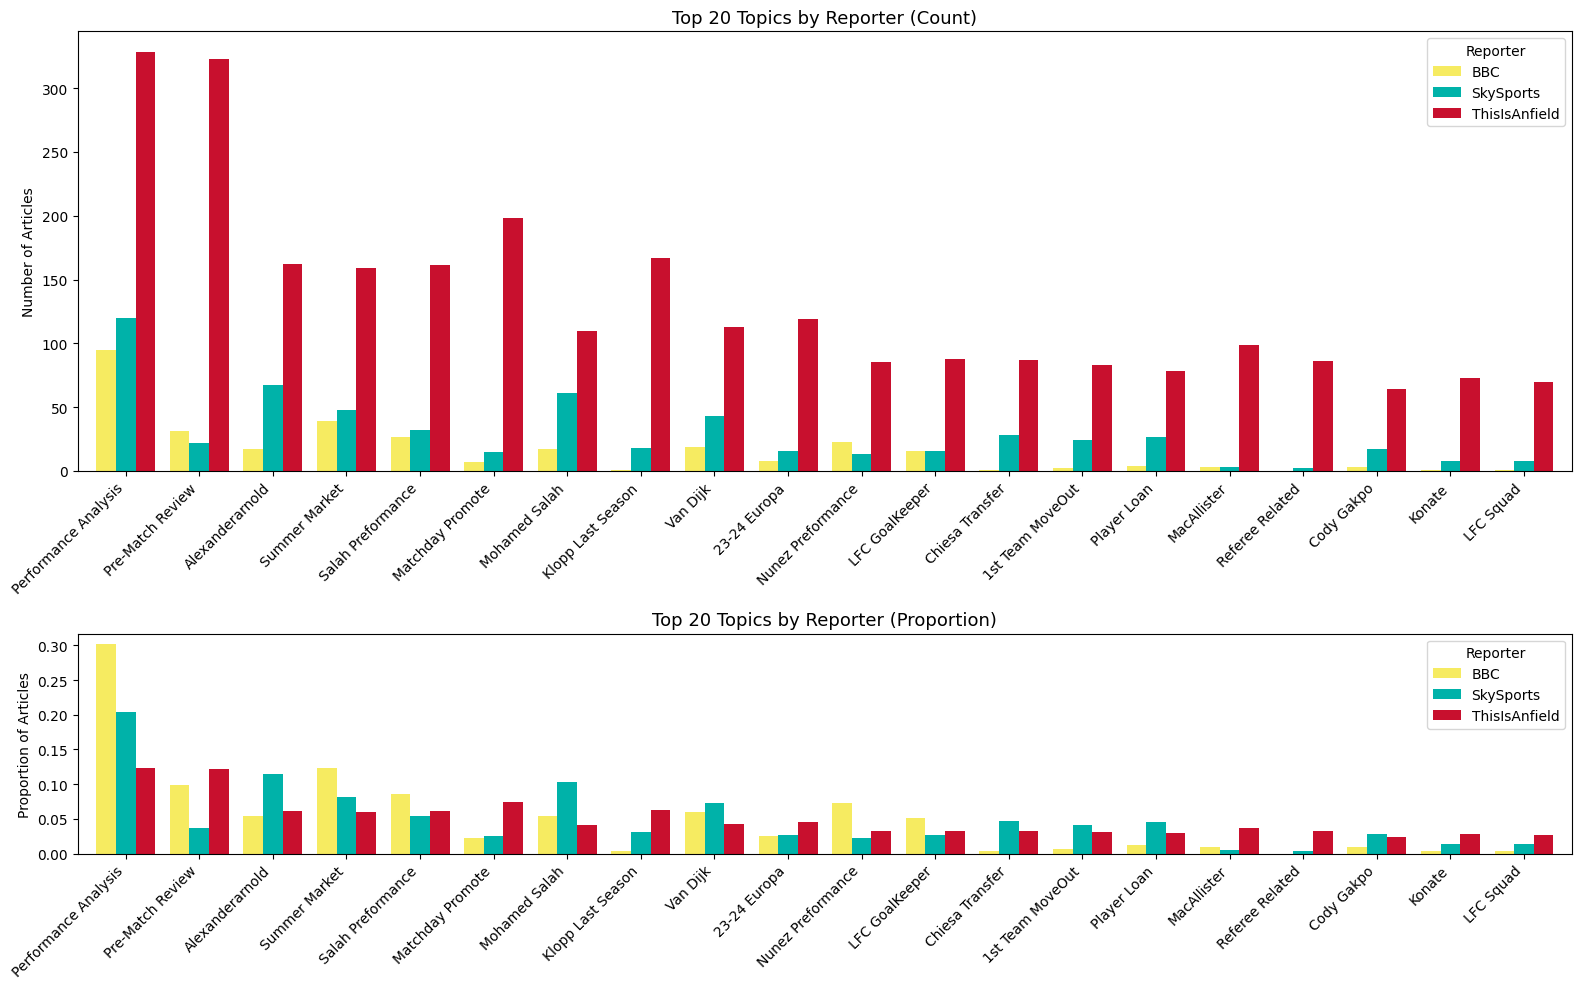

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

top_topics = lfc_df["lda_topic"].value_counts().nlargest(20).index.tolist()
filtered_df = lfc_df[lfc_df["lda_topic"].isin(top_topics)]

count_df = (filtered_df.groupby(["reporter", "lda_topic"]).size().reset_index(name="count"))

total_per_reporter = count_df.groupby("reporter")["count"].transform("sum")
count_df["proportion"] = count_df["count"] / total_per_reporter

pivot_count = count_df.pivot(index="lda_topic", columns="reporter", values="count").fillna(0)
pivot_prop = count_df.pivot(index="lda_topic", columns="reporter", values="proportion").fillna(0)

topic_order = pivot_count.sum(axis=1).sort_values(ascending=False).index.tolist()
pivot_count = pivot_count.loc[topic_order]
pivot_prop = pivot_prop.loc[topic_order]

pivot_count = pivot_count.iloc[:20]
pivot_prop = pivot_prop.iloc[:20]

custom_colors = ["#F6EB61", "#00B2A9", "#c8102E"]  # yellow, teal, red
reporter_order = ["BBC", "SkySports", "ThisIsAnfield"]
pivot_count = pivot_count[reporter_order]
pivot_prop = pivot_prop[reporter_order]

fig, axes = plt.subplots(2, 1, figsize=(16, 10), gridspec_kw={'height_ratios': [2, 1]})

pivot_count.plot(kind="bar", ax=axes[0], color=custom_colors, width=0.8)
axes[0].set_title("Top 20 Topics by Reporter (Count)", fontsize=13)
axes[0].set_ylabel("Number of Articles")

pivot_prop.plot(kind="bar", ax=axes[1], color=custom_colors, width=0.8)
axes[1].set_title("Top 20 Topics by Reporter (Proportion)", fontsize=13)
axes[1].set_ylabel("Proportion of Articles")

for ax in axes:
    ax.set_xlabel("")
    ax.set_xticks(range(len(pivot_count.index)))
    ax.set_xticklabels(pivot_count.index, rotation=45, ha="right")
    ax.legend(title="Reporter")

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

lfc_df["date"] = pd.to_datetime(lfc_df["date"], errors="coerce")
lfc_df = lfc_df.dropna(subset=["date"])
lfc_df["month"] = lfc_df["date"].dt.to_period("M").astype(str)
lfc_filtered = lfc_df[lfc_df["date"] >= "2024-01-01"].copy()

grouped = lfc_filtered.groupby(["reporter", "month"])

target_sample_size = 1000

group_counts = grouped.size().reset_index(name="count")

group_counts["sample_n"] = (group_counts["count"] / group_counts["count"].sum() * target_sample_size).round().astype(int)

sample_frames = []
for _, row in group_counts.iterrows():
    reporter, month, n = row["reporter"], row["month"], row["sample_n"]
    group_df = lfc_filtered[(lfc_filtered["reporter"] == reporter) & (lfc_filtered["month"] == month)]
    if len(group_df) >= n and n > 0:
        sample = group_df.sample(n=n, random_state=42)
        sample_frames.append(sample)

sampled_df = pd.concat(sample_frames).reset_index(drop=True)

sampled_df = sampled_df.sample(frac=1, random_state=42).reset_index(drop=True)

sampled_df.to_csv("lfc_sentiment_sample.csv", index=False)

print(f"Sampled {len(sampled_df)} articles saved to 'lfc_sentiment_sample.csv'")

Sampled 1001 articles saved to 'lfc_sentiment_sample.csv'


In [ ]:
import pandas as pd

lfc_url = "https://raw.githubusercontent.com/WinNatch/UoB_SM-WA/main/LFC_Sentiment_Self_label.csv"
lfc_stm = pd.read_csv(lfc_url, encoding="ISO-8859-1")

lda_topic_mapping = {
    "Salah contract": "Mohamed Salah",
    "LFC-Alonso": "Klopp Replacement",
    "LFC Derby": "Performance Analysis",
    "VanDijk Contract Renew": "Van Dijk"
}
lfc_stm["lda_topic"] = lfc_stm["lda_topic"].replace(lda_topic_mapping)

lfc_stm = lfc_stm.drop(columns=["time"], errors="ignore")

lfc_stm = lfc_stm[lfc_stm["news_text"].notna()]
lfc_stm = lfc_stm[lfc_stm["news_text"].str.strip() != ""]

print(lfc_stm.head())

         date                                           headline  \
0    5/1/2024  Jurgen Klopp could get surprise new job offer ...   
1   2/14/2025  Aston Villa made IMPOSSIBLE request to move Li...   
2  10/23/2024  Leipzig 0-1 Liverpool: Nunez goal provides pro...   
3    3/2/2025  Female Liverpool fans may be in for "surprise"...   
4    3/2/2024  "I would never try to wind Darwin up!" - Jurge...   

                                           news_text       reporter  \
0  Jurgen Klopp will take a deserved break follow...  ThisIsAnfield   
1  Aston Villa have seen a strange request to res...  ThisIsAnfield   
2  It wasn??t a classic but it needn??t to be, ...  ThisIsAnfield   
3  With International Women??s Day around the co...  ThisIsAnfield   
4  Darwin Nunez??s introduction from the bench s...  ThisIsAnfield   

                                                news  \
0  Jurgen Klopp could get surprise new job offer ...   
1  Aston Villa made IMPOSSIBLE request to move Li...

**Sentiment Analysis**

In [ ]:
rename_sen_label = {"n": "negative", "p": "positive", "s": "neutral"}

def label_decoder(label):
    return rename_sen_label[label]

lfc_stm['Sentiment_M'] = lfc_stm['Sentiment_M'].apply(lambda x: label_decoder(x))
lfc_stm.head()

,date,headline,news_text,reporter,news,clean_news,lda_no,lda_topic,month,Sentiment_M
0,5/1/2024,Jurgen Klopp could get surprise new job offer ...,Jurgen Klopp will take a deserved break follow...,ThisIsAnfield,Jurgen Klopp could get surprise new job offer ...,jurgen klopp could get surprise new job offer ...,7,Klopp Last Season,2024-05,neutral
1,2/14/2025,Aston Villa made IMPOSSIBLE request to move Li...,Aston Villa have seen a strange request to res...,ThisIsAnfield,Aston Villa made IMPOSSIBLE request to move Li...,aston villa made impossible request move fixtu...,5,Matchday Promote,2025-02,neutral
2,10/23/2024,Leipzig 0-1 Liverpool: Nunez goal provides pro...,"It wasn??t a classic but it needn??t to be, ...",ThisIsAnfield,Leipzig 0-1 Liverpool: Nunez goal provides pro...,leipzig nunez goal provides professional europ...,-1,NaN,2024-10,positive
3,3/2/2025,"Female Liverpool fans may be in for ""surprise""...",With International Women??s Day around the co...,ThisIsAnfield,"Female Liverpool fans may be in for ""surprise""...",female fans may surprise inspiring event next ...,43,LFC Women Team,2025-03,positive
4,3/2/2024,"""I would never try to wind Darwin up!"" - Jurge...",Darwin Nunez??s introduction from the bench s...,ThisIsAnfield,"""I would never try to wind Darwin up!"" - Jurge...",would never try wind darwin jurgen klopp st an...,-1,NaN,2024-03,negative


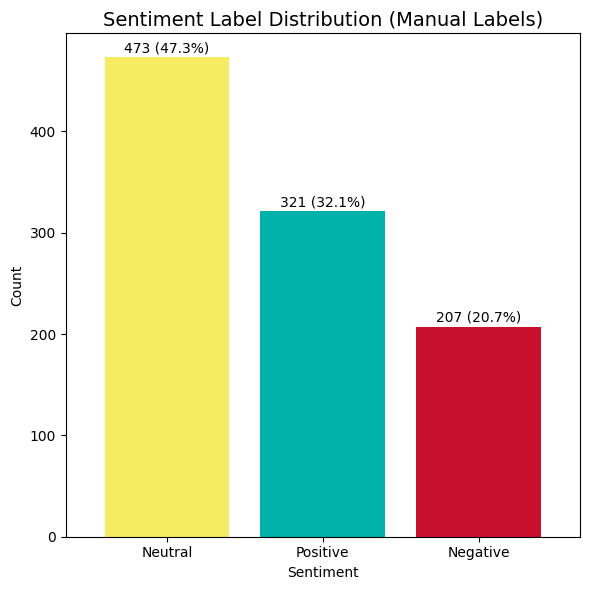

In [ ]:
import matplotlib.pyplot as plt

lfc_stm["Sentiment_M"] = lfc_stm["Sentiment_M"].str.title()

label_counts = lfc_stm["Sentiment_M"].value_counts()
label_proportions = label_counts / label_counts.sum()

color_map = {
    "Negative": "#C8102E",
    "Positive": "#00B2A9",
    "Neutral": "#F6EB61",
}

colors = [color_map[label] for label in label_counts.index]

fig, ax = plt.subplots(figsize=(6, 6))
label_counts.plot(kind="bar", color=colors, ax=ax, width=0.8)

for i, (count, label) in enumerate(zip(label_counts, label_counts.index)):
    ax.text(i, count + 5, f"{count} ({label_proportions[label]:.1%})",
            ha="center", fontsize=10)

ax.set_title("Sentiment Label Distribution (Manual Labels)", fontsize=14)
ax.set_xlabel("Sentiment")
ax.set_ylabel("Count")
ax.set_xticklabels(label_counts.index, rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
from nltk.corpus import stopwords
from nltk import download

download('stopwords')

nltk_stopwords = set(stopwords.words("english"))

custom_stopwords_sen = nltk_stopwords.union({
    # Coaching Staff 2023–2024 Season
    'jurgen', 'klopp', 'klopps', 'pepijn', 'lijnders', 'peter', 'krawietz',
    'john', 'achterberg', 'claudio', 'taffarel', 'andreas', 'kornmayer',

    # Common football terms (not useful for context)
    'match', 'goal', 'win', 'team', 'game', 'club', 'cup', 'season', 'player', 'manager', 'centre', 'back', 'football', 'wembley',
    'squad', 'side', 'performance', 'victory', 'score', 'final', 'campaign', 'start', 'position', 'result', 'supporter', 'end',
    'sport', 'defender', 'midfielder', 'forward', 'captain', 'goalkeeper', 'playmaker', 'teammate', 'fixture', 'fan', 'point', 'striker',
    'draw', 'competition', 'title', 'training', 'sign', 'signing', 'deal', 'offer', 'loan', 'penalty', 'scored', 'transfer', 'window',

    # Tournament Name
    'premier', 'league', 'ucl', 'europa', 'carabao', 'fa', 'uefa', 'fifa', 'championship', 'champion',

    # Days of the week and time related word
    'sunday', 'saturday', 'wednesday', 'friday', 'tuesday', 'monday', 'thursday', 'weekend', 'year', 'night', 'evening', 'afternoon', 'morning', 'preseason',

    # Months of the year
    'january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december',

    # Common football/journalistic phrases
    'last', 'summer', 'may', 'made', 'confirmed', 'following', 'next', 'take', 'put',
    'left', 'face', 'level', 'lot', 'half', 'record', 'former', 'strong', 'contract',
    'likely', 'expect', 'number', 'report', 'weekend', 'home', 'away', 'say', 'told', 'early', 'break', 'international', 'keep', 'kept',

    # Managerial words
    'coach', 'head', 'role', 'manager',

    # Number
    'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'eleven', 'twelve', 'thirteen', 'fourteen', 'fifteen', 'sixteen', 'seventeen', 'eighteen', 'nineteen', 'twenty',

    # Miscellaneous filler words
    'one', 'back', 'away', 'though', 'far', 'way', 'big', 'moment', 'move', 'made', 'take', 'news',
    'time', 'plan', 'really', 'change', 'need', 'always', 'think', 'given', 'england', 'big', 'man',

    # Other unnecessary terms
    'yearold', 'today', 'yesterday', 'tomorrow', 'said', 'says', 'week', 'month', 'day', 'already', 'new', 'thing',
    'still', 'good', 'best', 'first', 'second', 'time', 'minute', 'another', 'expected', 'well', 'thought', 'want', 'await',
    'going', 'know', 'needed', 'return', 'start', 'change', 'talk', 'chance', 'show', 'play', 'played', 'everything', 'every',

    # Liverpool-related terms (team, stadium, sponsors)
    'liverpool', 'lfc', 'anfield', 'axa', 'carabao', 'reds', 'kop', 'scouser', 'ynwa', 'merseyside', 'red',

    # Coaching Staff 2024–2025 Season
    'arne', 'slot', 'sipke', 'hulshoff', 'john', 'heitinga', 'fabian', 'otte',
    'claudio', 'taffarel', 'aaron', 'briggs', 'jonathan', 'power', 'lee', 'nobes',
    'conall', 'murtagh', 'ruben', 'peeters', 'chris', 'morgan', 'amit', 'pannu',
    'robin', 'sadler', 'paul', 'small', 'lee', 'radcliffe', 'brendan', 'mcilduff',
    'david', 'rydings', 'mona', 'nemmer', 'james', 'french', 'chris', 'black',
    'joe', 'lewis', 'clare', 'farrell', 'yinka', 'ademuyiwa', 'michelle', 'hudson', 'lynsey', 'ahmed',

    # Filler Words (Contextually Irrelevant)
    'see', 'look', 'came', 'came', 'making', 'taking', 'set', 'came', 'give', 'got', 'ahead', 'saw', 'yet', 'without', 'make', 'come',
    'remain', 'early', 'late', 'interest', 'decision', 'including', 'revealed', 'situation', 'part', 'much', 'place', 'visit', 'many', 'right',
    'charge', 'situation', 'explain', 'hope', 'better', 'key', 'due', 'stay', 'came', 'future', 'past', 'leave', 'recent', 'almost', 'include',

    # Fenway Sports Group (FSG) & Key Personnel
    'fsg', 'fenway', 'sports', 'group',  # Adding "FSG" and its variations
    'john', 'henry', 'tom', 'werner', 'michael', 'gordon', 'sam', 'kennedy',
    'lebron', 'james', 'maverick', 'carter', 'paul', 'wachter', 'adam', 'grossman',
    'ryan', 'fischer', 'theo', 'epstein', 'billy', 'hogan', 'ed', 'weiss', 'julie', 'swinehart',

    # Player names (to remove bias in LDA and sentiment)
    'alisson', 'adrian', 'caoimhin', 'kelleher', 'trent', 'alexanderarnold', 'alexander', 'arnold',
    'joe', 'gomez', 'virgil', 'van', 'dijk', 'ibrahima', 'konate', 'joel', 'matip', 'mohame',
    'andrew', 'robertson', 'kostas', 'tsimikas', 'nat', 'phillips', 'rhys', 'williams',
    'jarell', 'quansah', 'conor', 'bradley', 'amara', 'nallo', 'wataru', 'endo', 'thiago',
    'dominik', 'szoboszlai', 'alexis', 'mac', 'allister', 'curtis', 'jones', 'harvey', 'elliott',
    'ryan', 'gravenberch', 'tyler', 'morton', 'bobby', 'clark', 'stefan', 'bajcetic',
    'james', 'mcconnell', 'luis', 'diaz', 'darwin', 'nunez', 'mohamed', 'salah', 'diogo', 'jota',
    'cody', 'gakpo', 'federico', 'chiesa', 'kaide', 'gordon', 'ben', 'doak', 'lewis', 'koumas',
    'jayden', 'danns', 'vitezslav', 'jaros', 'harvey', 'davies',

    # Liverpool FC Opponents from January 2024 to March 2025 (Premier League & Domestic Cups)
    'newcastle', 'united', 'afc', 'bournemouth', 'chelsea', 'arsenal', 'burnley',
    'brentford', 'luton', 'town', 'nottingham', 'forest', 'manchester', 'city',
    'brighton', 'hove', 'albion', 'sheffield', 'crystal', 'palace', 'fulham',
    'everton', 'west', 'ham', 'tottenham', 'hotspur', 'aston', 'villa',
    'wolverhampton', 'wanderers', 'ipswich', 'southampton', 'leicester', 'wolf',

    # UEFA Champions League & Europa League Opponents
    'milan', 'bologna', 'rb', 'leipzig', 'real', 'madrid', 'girona', 'psv', 'eindhoven',
    'lille', 'psg', 'paris', 'saintgermain', 'lask', 'union', 'gilloise', 'toulouse',
    'sparta', 'prague', 'atalanta', 'leverkusen'
})

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import pandas as pd
import re
import spacy
from nltk.corpus import stopwords
from nltk import download
from tqdm import tqdm

lfc_df = lfc_df[lfc_df["news_text"].notna()]
lfc_df = lfc_df[lfc_df["news_text"].str.strip() != ""]

nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])

def build_full_text(df):
    df['headline'] = df['headline'].fillna('').astype(str)
    df['news_text'] = df['news_text'].fillna('').astype(str)
    df['full_text'] = df['headline'] + ' ' + df['news_text']
    return df

lfc_stm = build_full_text(lfc_stm)
lfc_df = build_full_text(lfc_df)

def clean_and_lemmatize(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|[^a-z\s]", " ", text)
    doc = nlp(text)
    tokens = [
        token.lemma_ for token in doc
        if token.lemma_ not in custom_stopwords_sen and len(token.lemma_) > 2 and token.is_alpha
    ]
    return " ".join(tokens)

tqdm.pandas()
lfc_stm['clean_news_st'] = lfc_stm['full_text'].progress_apply(clean_and_lemmatize)
lfc_df['clean_news_st'] = lfc_df['full_text'].progress_apply(clean_and_lemmatize)

100%|██████████| 7531/7531 [01:09<00:00, 107.67it/s]


In [ ]:
print(lfc_stm.info())
print(lfc_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   date           1001 non-null   object
 1   headline       1001 non-null   object
 2   news_text      1001 non-null   object
 3   reporter       1001 non-null   object
 4   news           1001 non-null   object
 5   clean_news     1001 non-null   object
 6   lda_no         1001 non-null   int64 
 7   lda_topic      740 non-null    object
 8   month          1001 non-null   object
 9   Sentiment_M    1001 non-null   object
 10  full_text      1001 non-null   object
 11  clean_news_st  1001 non-null   object
dtypes: int64(1), object(11)
memory usage: 94.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 7531 entries, 0 to 7546
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           7531 non-n

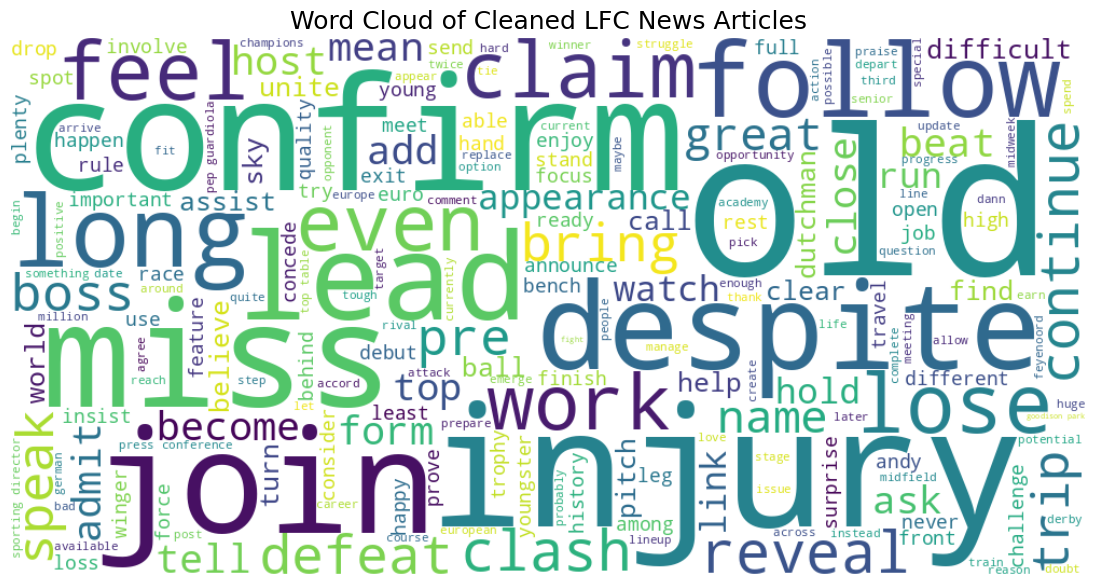

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_text = " ".join(lfc_df['clean_news_st'].dropna())

wordcloud = WordCloud(
    width=1000,
    height=500,
    background_color='white',
    colormap='viridis',
    max_words=200
).generate(all_text)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Cleaned LFC News Articles", fontsize=18)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

color_map = {
    "Negative": "#C8102E",
    "Positive": "#00B2A9",
    "Neutral": "#F6EB61",
}

label_counts_before = lfc_stm['Sentiment_M'].value_counts()

def plot_label_distribution(before, after, label_order):
    fig, axes = plt.subplots(1, 2, figsize=(14, 7))
    for ax, data, title in zip(
        axes,
        [before, after],
        ["Before SMOTE", "After SMOTE (Train Set)"]
    ):
        total = data.sum()
        sns.barplot(
            x=data.index,
            y=data.values,
            ax=ax,
            palette=[color_map[label] for label in label_order],
            order=label_order
        )
        for i, v in enumerate(data[label_order]):
            ax.text(i, v + 5, f"{v} ({v/total:.1%})", ha='center', fontsize=12)
        ax.set_title(title)
        ax.set_ylabel("Count")
        ax.set_xlabel("Sentiment")
    fig.suptitle("Sentiment Label Distribution: Before vs After SMOTE", fontsize=16)
    plt.tight_layout()
    plt.show()

<ipython-input-38-05f23055473d>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-38-05f23055473d>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


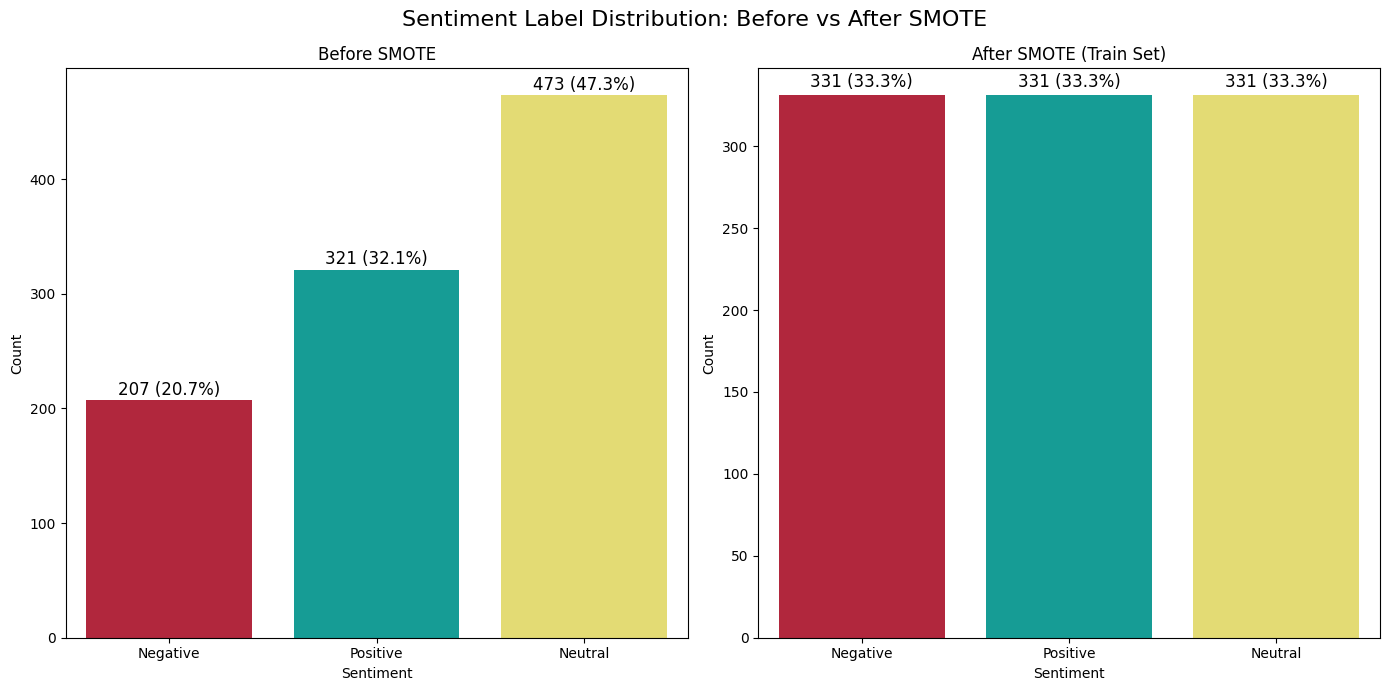

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

le = LabelEncoder()
lfc_stm['label'] = le.fit_transform(lfc_stm['Sentiment_M'])

tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(lfc_stm['clean_news_st'])
y = lfc_stm['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

after_counts = pd.Series(le.inverse_transform(y_train_resampled)).value_counts()

label_order = ["Negative", "Positive", "Neutral"]
plot_label_distribution(label_counts_before, after_counts, label_order)


📊 Logistic Regression Evaluation
----------------------------------------
Train Accuracy: 0.9778
Test Accuracy : 0.5449

Classification Report:
              precision    recall  f1-score   support

    Negative       0.40      0.31      0.35        62
     Neutral       0.61      0.68      0.64       142
    Positive       0.52      0.51      0.51        97

    accuracy                           0.54       301
   macro avg       0.51      0.50      0.50       301
weighted avg       0.53      0.54      0.54       301



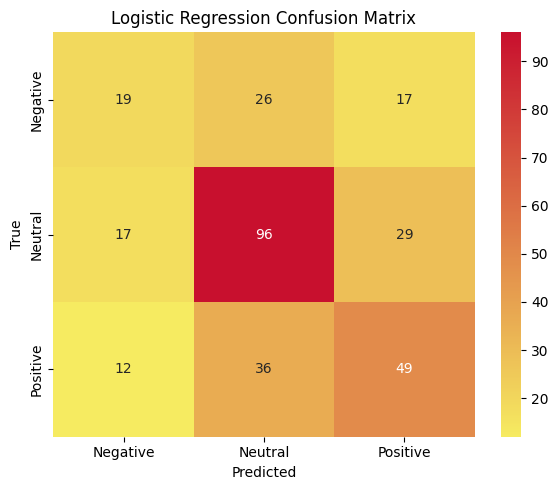


📊 Naive Bayes Evaluation
----------------------------------------
Train Accuracy: 0.9527
Test Accuracy : 0.515

Classification Report:
              precision    recall  f1-score   support

    Negative       0.35      0.42      0.38        62
     Neutral       0.64      0.52      0.58       142
    Positive       0.49      0.57      0.53        97

    accuracy                           0.51       301
   macro avg       0.50      0.50      0.49       301
weighted avg       0.53      0.51      0.52       301



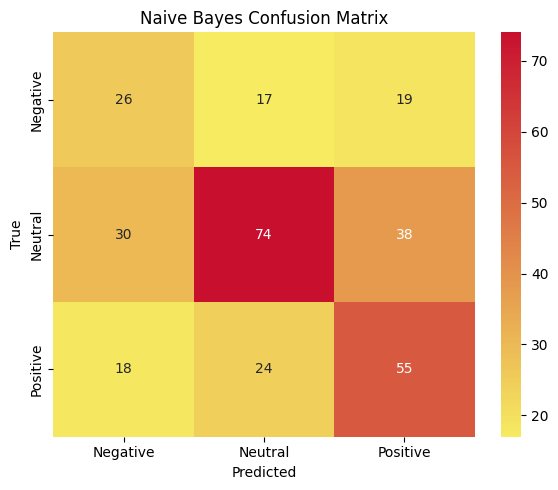

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

colors = ["#F6EB61", "#C8102E"]
custom_cmap = LinearSegmentedColormap.from_list("custom_red_yellow", colors, N=256)

class_names = le.classes_  # 'Negative', 'Neutral', 'Positive'

def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    print(f"\n📊 {name} Evaluation")
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    print("-" * 40)
    print("Train Accuracy:", round(accuracy_score(y_train, y_train_pred), 4))
    print("Test Accuracy :", round(accuracy_score(y_test, y_test_pred), 4))
    print("\nClassification Report:")
    print(classification_report(y_test, y_test_pred, target_names=class_names))

    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap=custom_cmap,
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

lr_model = LogisticRegression(max_iter=1000, random_state=42)
nb_model = MultinomialNB()

evaluate_model("Logistic Regression", lr_model, X_train_resampled, y_train_resampled, X_test, y_test)
evaluate_model("Naive Bayes", nb_model, X_train_resampled, y_train_resampled, X_test, y_test)